# BI - Laboratorio 1
Santiago Casasbuenas - 202214932
Manuel Gomez - xxxxxx
Juan Pablo Castro - xxxxxx

## 0. Imports

In [17]:
%matplotlib inline

In [18]:
# -------------------------------------------
# Librerías para manipulación y cálculo numérico
import numpy as np
import pandas as pd

# Configuración de pandas para visualizar más filas y columnas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

# -------------------------------------------
# Utilidades para guardar y cargar modelos
from joblib import dump, load

# -------------------------------------------
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# Herramientas de scikit-learn para preparación de datos y modelado
# División de datos, regresión lineal y creación de pipelines y transformaciones
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Métricas para evaluar el modelo de regresión
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------
# Funciones estadísticas adicionales
import scipy.stats as stats

# -------------------------------------------
# Librerías para análisis de datos
from ydata_profiling import ProfileReport

## 1. Carga de datos
En esta sección se explica cómo se carga el conjunto de datos que se utilizará a lo largo del laboratorio. Se suele emplear la función pd.read_csv (o funciones similares) para leer archivos con formato CSV, Excel u otros, permitiendo convertir la información en un DataFrame de pandas. Así, se asegura que la data esté disponible para realizar análisis exploratorio, procesamiento y modelado posterior.

In [19]:
# Carga de datos
star_df = pd.read_csv("./train_data.csv")

In [20]:
# Información general del dataset
star_df.shape

(4000, 18)

## 2. Entendimiento de los datos
Se realizará un perfilamiento de los datos utlizando pandas_profiling para obtener una visión general que nos permita identificar potenciales problemas en variables específicas y en las relaciones entre ellas. Después, se efectuará un análisis numérico a través de gráficas de dispersión e histogramas para estudiar la distribución y la correlación de las variables cuantitativas. Paralelamente, se llevará a cabo un análisis categórico utilizando boxplots para visualizar la variación y detectar outliers en las variables cualitativas. Además, se incluirá un análisis de calidad de los datos que evaluará la completitud, unicidad, consistencia y validez de la información disponible.


### 2.1 Primer análisis de variables numéricas y categoricas

#### 2.1.1 Análisis Numérico - Gráficas de dispersión e histogramas
En esta sección se explorará la distribución y relaciones de las variables numéricas del conjunto de datos. Se utilizarán gráficas de dispersión para visualizar la relación entre pares de variables de interés y detectar patrones o posibles outliers. Asimismo, se generarán histogramas para analizar la distribución de cada variable, permitiendo identificar sesgos o concentraciones inusuales. Estas visualizaciones serán fundamentales para entender el comportamiento de la data antes de proceder con transformaciones o modelado.


In [21]:
numericas = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field', 'clean', 'redshift', 'mjd', 'rowv', 'colv', 'objid']

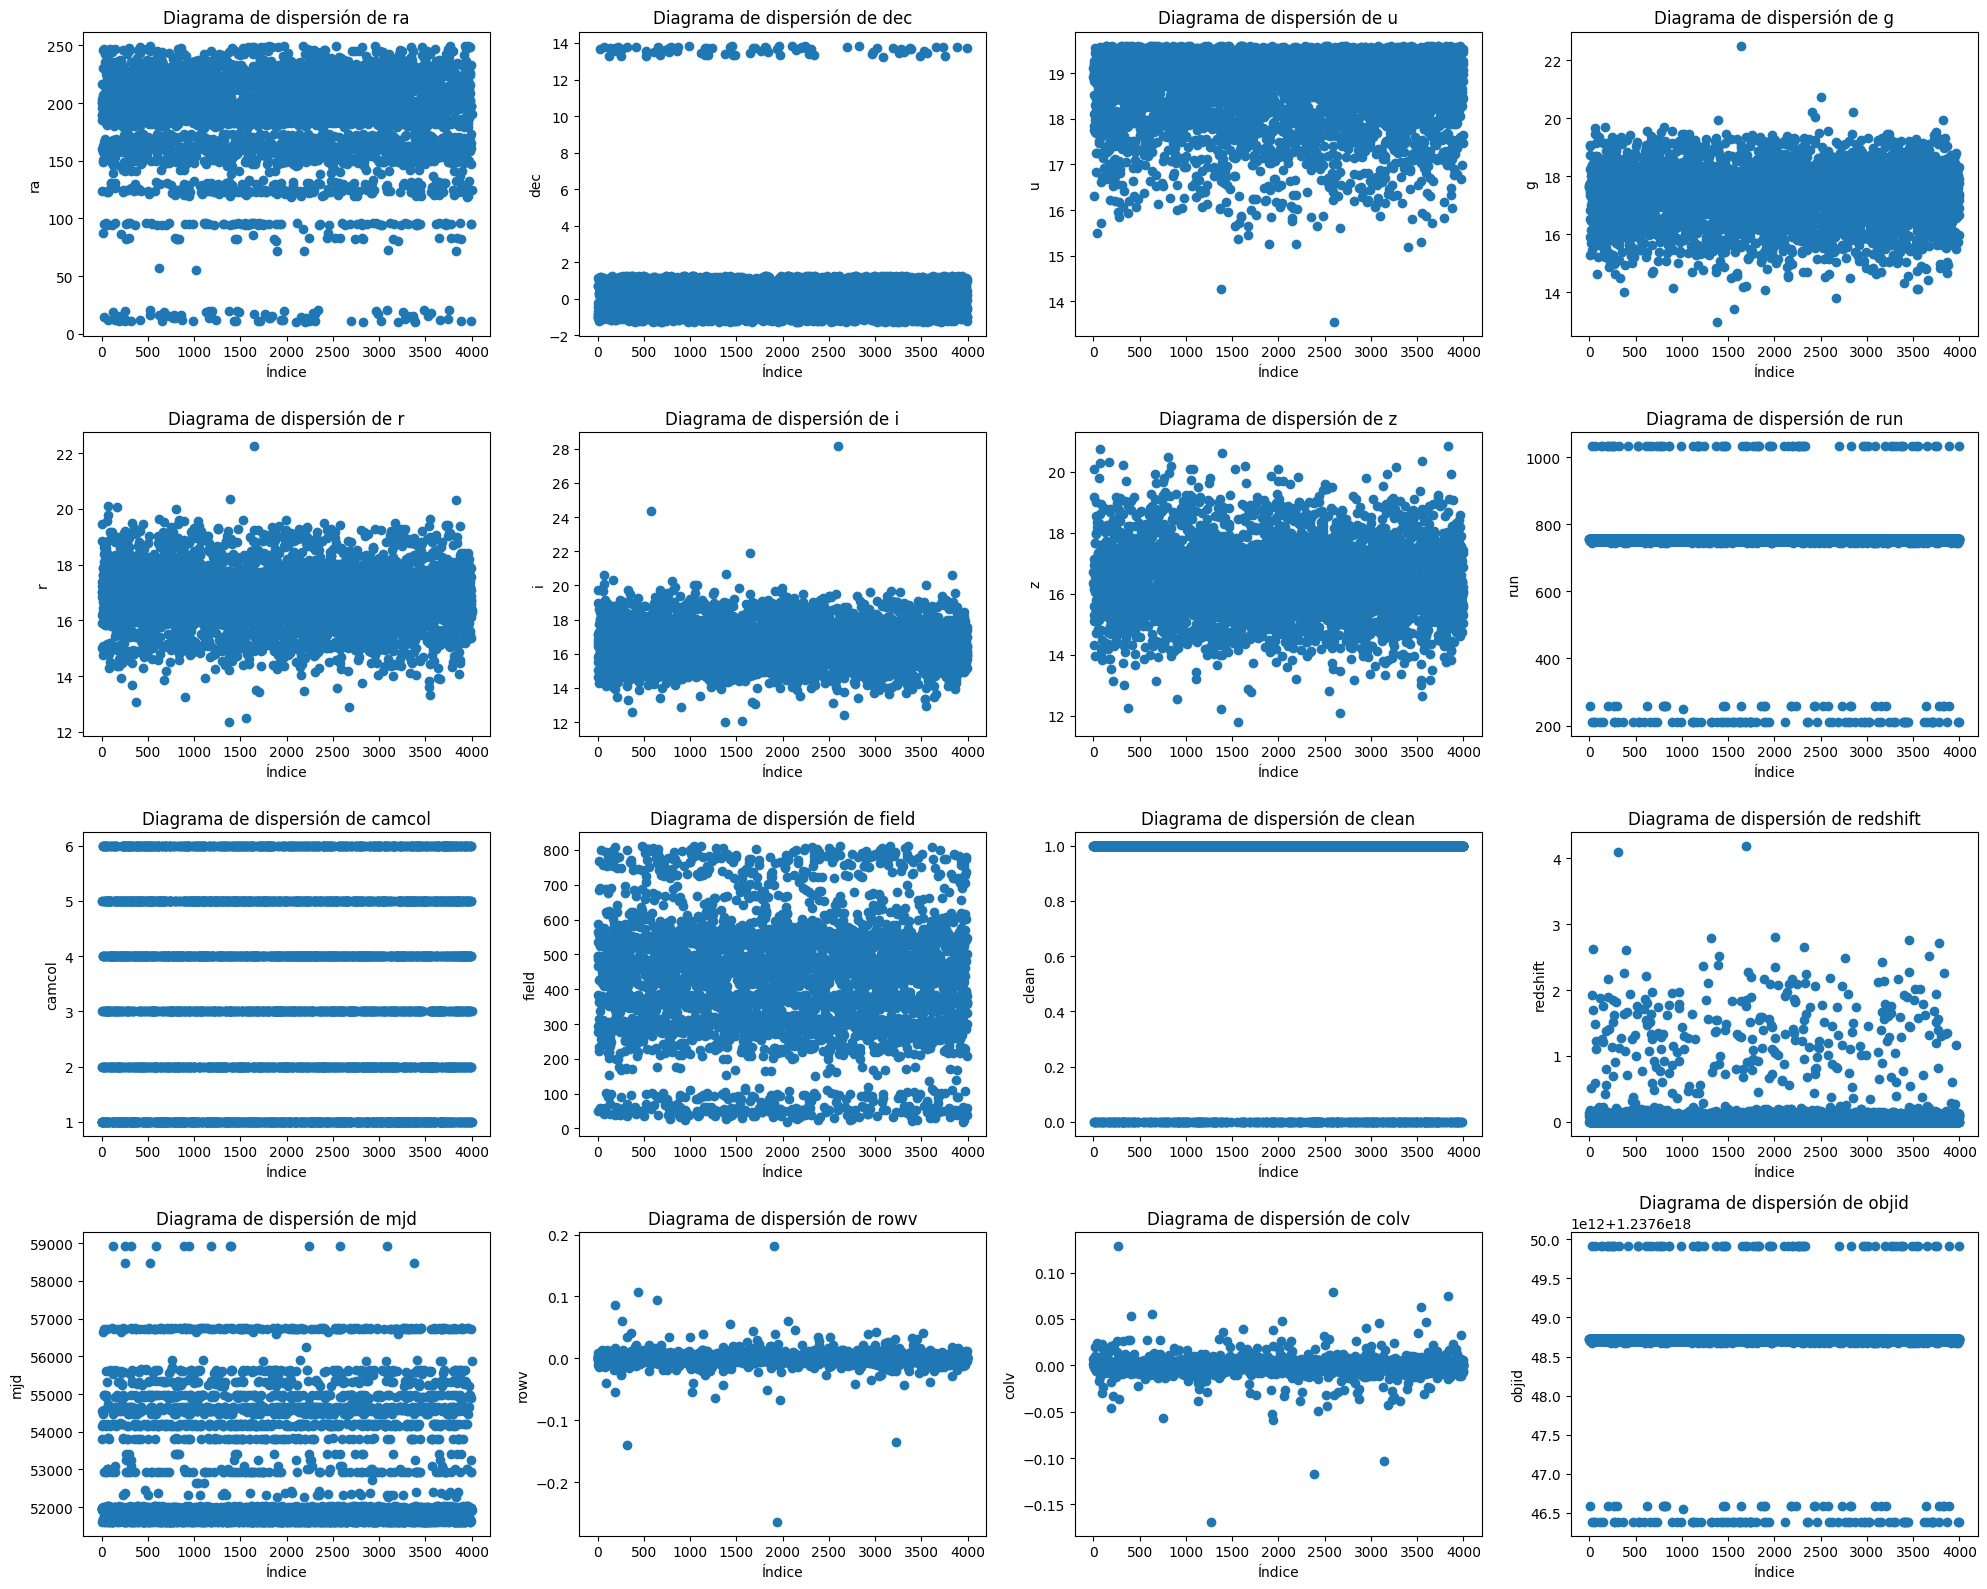

In [26]:
# Calcular el número de filas necesarias en base a columnas por fila
columnas_por_fila = 4
filas = int(np.ceil(len(numericas) / columnas_por_fila))
figura, ejes = plt.subplots(filas, columnas_por_fila, figsize=(columnas_por_fila * 5, filas * 4))
ejes = ejes.flatten()

# Graficar cada columna numérica en un subplot separado
for eje, columna in zip(ejes, numericas):
    eje.scatter(star_df.index, star_df[columna])
    eje.set_xlabel("Índice")
    eje.set_ylabel(columna)
    eje.set_title(f"Diagrama de dispersión de {columna}")

# Ocultar subplots extras
for eje in ejes[len(numericas):]:
    eje.set_visible(False)

plt.tight_layout()
plt.show()


#### 2.1.2 Análisis Categórico - Boxplots

### 2.2 Perfilamiento con pandas_profiling
En esta sección se utilizará pandas_profiling para generar un informe detallado del dataset. El reporte incluirá análisis estadísticos exploratorios como la distribución de las variables, la identificación de valores nulos, la detección de posibles outliers y la evaluación de la correlación entre las variables. Esto permitirá obtener una visión general de la calidad y estructura de los datos, facilitando la preparación y limpieza antes del modelado.

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

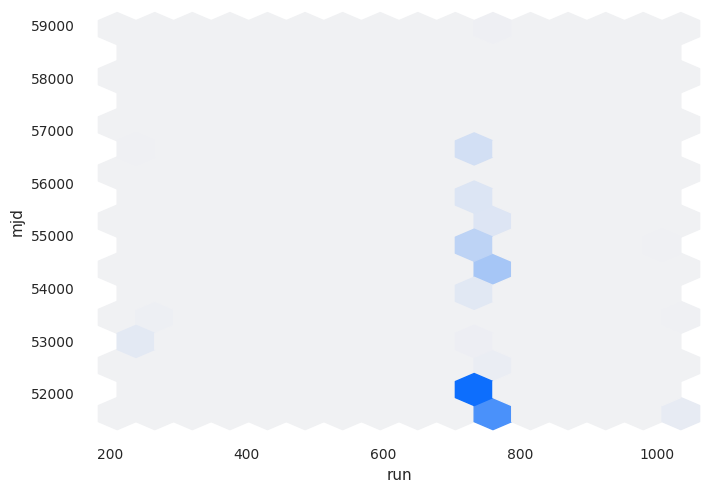

In [23]:
# Perfilamiento de los datos a través de ydata_profiling
# profile = ProfileReport(star_df, title='StarAlpes Data - Profiling Report', explorative=True)
# profile

#### 2.2.1 Análisis del perfilamiento
##### 2.2.1.1 Alertas encontradas por el programa
Se obtuvieron 13 alertas. En estas, se destacan 3 aspectos importantes.

1. **Filas Duplicadas**
    - **Problema:** Hay 17 filas duplicadas en el conjunto de datos.

    - **Acción:** Se tomará la acción de eliminar estos duplicados para asegurar la integridad del análisis y evitar sesgos en los modelos de aprendizaje automático.

2. **Alta Correlación entre Variables**
    - **Problema:** Varias variables muestran alta correlación con otras, lo que puede indicar redundancia en la información. Se destacan entre ellas las siguientes similitudes:
        - `camcol` y `dec`
        - `dec` con `camcol` y otro campo
        - `field` y `ra`
        - `g`, `i`, `r`, `u`, `z` están altamente correlacionadas entre sí
        - `objid` con `dec` y otro campo
        - `run` y `objid`

    - **Acción:** En este se tomará la acción de tomar las variables que se consideren más importantes para resolver el problema del negocio. Por ejemplo: g, i, r, u, z todas hacen referencia a la magnitud del objeto, pero cada una representa un filtro distinto, debemos revisar la correlación entre la variable objetivo y estas y determinar cuales tienen una mayor correlación.

3. **Desbalance en 'clean'**
    - **Problema:** La varibale `clean`, que indica si la fotometría del objeto es limpia está desbalanceada (51.7%).
    
    - **Acción:** En este caso, se tomara la acción de retirar aquellos registros donde donde se indique que la fotometría no es limpia, ya que el diccionario nos indica que aquellas que no son limpias, no son confiables. 